# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.42KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

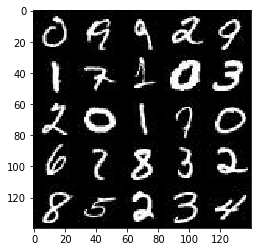

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

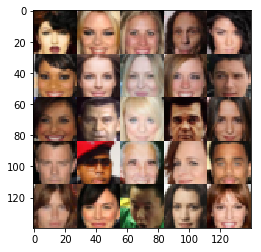

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 32x32x3 now

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
import os

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
    
    # TODO: Build Model
    n, h, w, d = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(h, w, d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    samples, losses = [], []
    steps = 0    
    print_every = 10
    show_every = 100
    n_images = 16
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                                input_z: batch_z,
                                                learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                                input_real: batch_images,
                                                learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, d, data_image_mode)
  
        print('saving generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')                     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0254... Generator Loss: 4.9456
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 1.4607
Epoch 1/2... Discriminator Loss: 0.1670... Generator Loss: 1.9927
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 16.9552
Epoch 1/2... Discriminator Loss: 5.6996... Generator Loss: 0.0066
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.2734
Epoch 1/2... Discriminator Loss: 2.7793... Generator Loss: 0.1178
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 0.9327


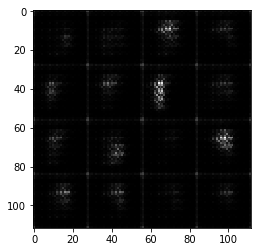

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 0.3791... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 2.9461
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 2.8894... Generator Loss: 0.1078
Epoch 1/2... Discriminator Loss: 2.3490... Generator Loss: 7.0656
Epoch 1/2... Discriminator Loss: 0.2638... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.2078... Generator Loss: 3.8726
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 0.2002... Generator Loss: 2.4721


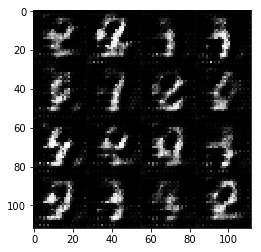

Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 8.9117
Epoch 1/2... Discriminator Loss: 0.0764... Generator Loss: 4.0211
Epoch 1/2... Discriminator Loss: 0.0913... Generator Loss: 3.0772
Epoch 1/2... Discriminator Loss: 0.1303... Generator Loss: 2.5180
Epoch 1/2... Discriminator Loss: 0.2911... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 11.9850... Generator Loss: 27.1327
Epoch 1/2... Discriminator Loss: 0.2136... Generator Loss: 2.6973
Epoch 1/2... Discriminator Loss: 0.3011... Generator Loss: 2.0014
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 2.3186
Epoch 1/2... Discriminator Loss: 0.0303... Generator Loss: 4.0631


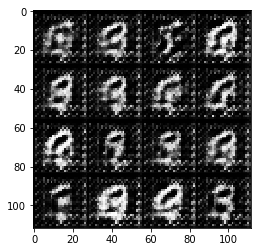

Epoch 1/2... Discriminator Loss: 0.0056... Generator Loss: 6.8409
Epoch 1/2... Discriminator Loss: 0.0582... Generator Loss: 3.3562
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 2.2868
Epoch 1/2... Discriminator Loss: 0.0331... Generator Loss: 3.8341
Epoch 1/2... Discriminator Loss: 0.2660... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 0.1991... Generator Loss: 8.0707
Epoch 1/2... Discriminator Loss: 0.1363... Generator Loss: 2.9814
Epoch 1/2... Discriminator Loss: 3.2301... Generator Loss: 0.0539
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 3.1338


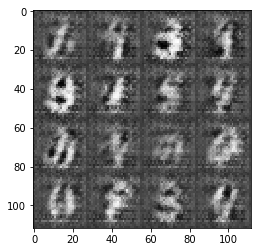

Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 1.3808
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 5.7840
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 2.3088
Epoch 1/2... Discriminator Loss: 0.4925... Generator Loss: 3.2981
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.3753
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 2.1208
Epoch 1/2... Discriminator Loss: 0.4680... Generator Loss: 2.2692
Epoch 1/2... Discriminator Loss: 1.9325... Generator Loss: 0.2244
Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 3.9493


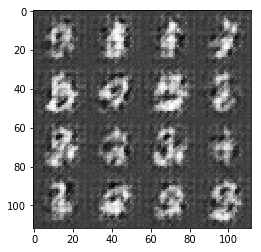

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 4.3995
Epoch 1/2... Discriminator Loss: 0.3143... Generator Loss: 2.7523
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 2.3057... Generator Loss: 3.3695
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 0.2545... Generator Loss: 1.9928
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 1.3354
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 0.9212


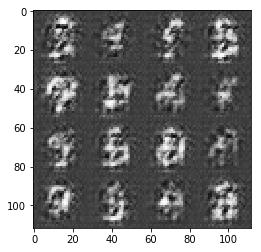

Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 0.1627... Generator Loss: 2.7672
Epoch 1/2... Discriminator Loss: 0.3350... Generator Loss: 1.7808
Epoch 1/2... Discriminator Loss: 0.1798... Generator Loss: 2.4912
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 1.9230
Epoch 1/2... Discriminator Loss: 0.4910... Generator Loss: 1.1766


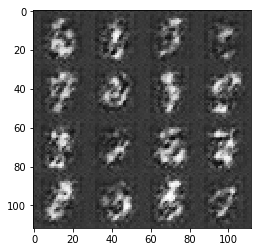

Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 2.0235
Epoch 1/2... Discriminator Loss: 0.1813... Generator Loss: 2.8479
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 0.9714
Epoch 1/2... Discriminator Loss: 0.6955... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 0.1150... Generator Loss: 2.4749
Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 1.3865
Epoch 1/2... Discriminator Loss: 0.3174... Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 2.4683... Generator Loss: 8.8097


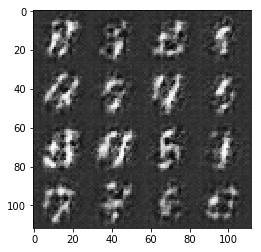

Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 0.4157... Generator Loss: 1.6480
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 1.4294
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.4335... Generator Loss: 1.3785
Epoch 1/2... Discriminator Loss: 0.1816... Generator Loss: 2.1038
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 0.2235... Generator Loss: 2.6538
Epoch 1/2... Discriminator Loss: 0.1635... Generator Loss: 2.3152
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 0.8431


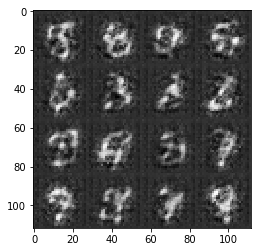

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 0.1455... Generator Loss: 2.5531
Epoch 1/2... Discriminator Loss: 0.1271... Generator Loss: 2.4335
Epoch 1/2... Discriminator Loss: 0.3223... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 3.8175
Epoch 1/2... Discriminator Loss: 0.0493... Generator Loss: 3.4342
Epoch 1/2... Discriminator Loss: 9.9589... Generator Loss: 12.6337
Epoch 1/2... Discriminator Loss: 0.2809... Generator Loss: 2.2189
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 1.0877


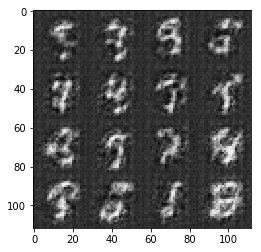

Epoch 1/2... Discriminator Loss: 0.4284... Generator Loss: 1.2129
Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 1.4917
Epoch 1/2... Discriminator Loss: 4.0859... Generator Loss: 6.7637
Epoch 1/2... Discriminator Loss: 0.3959... Generator Loss: 2.1227
Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 1.9790
Epoch 1/2... Discriminator Loss: 0.3197... Generator Loss: 1.9361
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 0.3276... Generator Loss: 1.7475
Epoch 1/2... Discriminator Loss: 0.3096... Generator Loss: 1.7035
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 0.8195


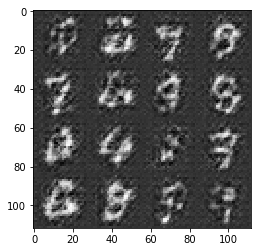

Epoch 1/2... Discriminator Loss: 0.2064... Generator Loss: 2.2286
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 0.2757... Generator Loss: 1.7501
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 1.8035
Epoch 1/2... Discriminator Loss: 0.0396... Generator Loss: 4.0726
Epoch 1/2... Discriminator Loss: 0.0293... Generator Loss: 4.9438
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 0.1071... Generator Loss: 3.5727
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 1.6623


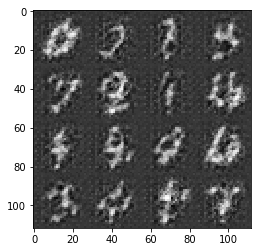

Epoch 1/2... Discriminator Loss: 0.1641... Generator Loss: 2.1418
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 0.3069... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 0.0855... Generator Loss: 2.6878
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 0.2058... Generator Loss: 1.9055
Epoch 1/2... Discriminator Loss: 0.0656... Generator Loss: 3.1628
Epoch 1/2... Discriminator Loss: 0.0202... Generator Loss: 5.3321


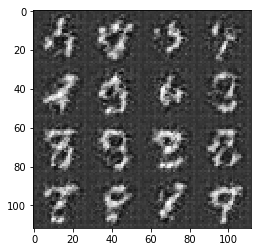

Epoch 1/2... Discriminator Loss: 0.1776... Generator Loss: 2.3398
Epoch 1/2... Discriminator Loss: 0.0936... Generator Loss: 2.6800
Epoch 1/2... Discriminator Loss: 0.0385... Generator Loss: 3.7100
Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 3.0655
Epoch 1/2... Discriminator Loss: 0.0288... Generator Loss: 4.8367
Epoch 1/2... Discriminator Loss: 0.2364... Generator Loss: 1.8757
Epoch 1/2... Discriminator Loss: 2.3311... Generator Loss: 0.1251
Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 2.1581
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 3.7349


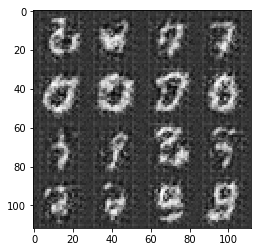

Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.3743
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 0.1417... Generator Loss: 2.5128
Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 0.1321... Generator Loss: 5.2743
Epoch 1/2... Discriminator Loss: 0.0517... Generator Loss: 3.6798
Epoch 1/2... Discriminator Loss: 0.0768... Generator Loss: 3.1338
Epoch 1/2... Discriminator Loss: 0.1159... Generator Loss: 2.6334
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.0453


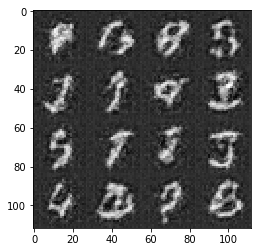

Epoch 1/2... Discriminator Loss: 0.1201... Generator Loss: 2.7427
Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 2.4349
Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 3.9670
Epoch 1/2... Discriminator Loss: 0.2264... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 0.0138... Generator Loss: 6.0564
Epoch 1/2... Discriminator Loss: 0.0206... Generator Loss: 4.7664
Epoch 1/2... Discriminator Loss: 0.1380... Generator Loss: 2.4904
Epoch 1/2... Discriminator Loss: 0.0163... Generator Loss: 5.0840
Epoch 1/2... Discriminator Loss: 0.0539... Generator Loss: 3.1252
Epoch 1/2... Discriminator Loss: 2.8904... Generator Loss: 7.4685


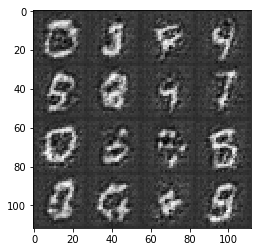

Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.4620
Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 1.1086
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 2.6286
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.4112
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 5.4651
Epoch 1/2... Discriminator Loss: 1.5238... Generator Loss: 0.3090
Epoch 1/2... Discriminator Loss: 0.3264... Generator Loss: 1.6496
Epoch 1/2... Discriminator Loss: 2.4053... Generator Loss: 0.3140


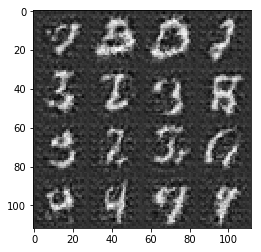

Epoch 1/2... Discriminator Loss: 0.2902... Generator Loss: 4.5257
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 2.1166
Epoch 1/2... Discriminator Loss: 0.4675... Generator Loss: 3.0589
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 2.0782
Epoch 1/2... Discriminator Loss: 0.1199... Generator Loss: 3.2750
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 0.3319... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 0.1035... Generator Loss: 2.9425
Epoch 1/2... Discriminator Loss: 0.1802... Generator Loss: 2.2440
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 0.8875


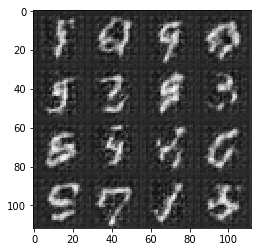

Epoch 1/2... Discriminator Loss: 0.3045... Generator Loss: 2.4593
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 0.2800... Generator Loss: 3.7457
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 2.2805... Generator Loss: 0.2481
Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 1.1001
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 0.9326


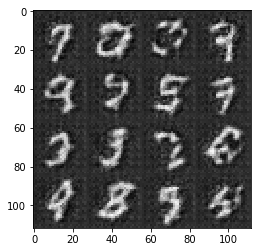

Epoch 1/2... Discriminator Loss: 0.1183... Generator Loss: 2.7111
Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 1.7007
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 0.0451... Generator Loss: 3.5539
Epoch 1/2... Discriminator Loss: 0.4705... Generator Loss: 1.1845
Epoch 1/2... Discriminator Loss: 0.2381... Generator Loss: 1.6963
Epoch 1/2... Discriminator Loss: 0.0861... Generator Loss: 2.9783
Epoch 1/2... Discriminator Loss: 0.2840... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 0.1589... Generator Loss: 2.1973
Epoch 1/2... Discriminator Loss: 0.4162... Generator Loss: 1.3466


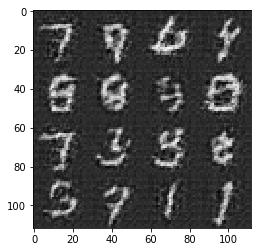

Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 0.0228... Generator Loss: 4.8638
Epoch 1/2... Discriminator Loss: 0.2360... Generator Loss: 1.6624
Epoch 1/2... Discriminator Loss: 0.0774... Generator Loss: 2.9904
Epoch 1/2... Discriminator Loss: 0.0438... Generator Loss: 3.4829
Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 1.8931
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 0.0672... Generator Loss: 2.9545
Epoch 1/2... Discriminator Loss: 0.0322... Generator Loss: 3.7851
Epoch 1/2... Discriminator Loss: 0.1138... Generator Loss: 2.5919


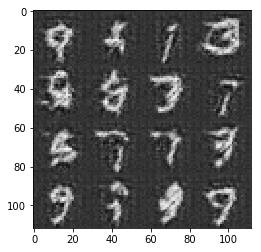

Epoch 1/2... Discriminator Loss: 0.0533... Generator Loss: 3.6044
Epoch 1/2... Discriminator Loss: 0.0568... Generator Loss: 3.6370
Epoch 1/2... Discriminator Loss: 0.0596... Generator Loss: 3.3545
Epoch 1/2... Discriminator Loss: 0.0233... Generator Loss: 5.1245
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.4296
Epoch 1/2... Discriminator Loss: 0.4295... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 1.1235
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 1.2901
Epoch 1/2... Discriminator Loss: 0.3433... Generator Loss: 1.9848


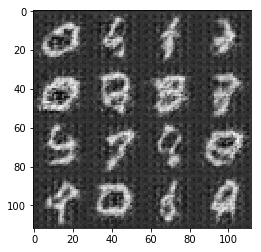

Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 0.7151... Generator Loss: 1.2927
Epoch 1/2... Discriminator Loss: 0.5006... Generator Loss: 2.7472
Epoch 1/2... Discriminator Loss: 0.3082... Generator Loss: 1.9120
Epoch 1/2... Discriminator Loss: 2.0482... Generator Loss: 0.2365
Epoch 1/2... Discriminator Loss: 2.5472... Generator Loss: 0.1922
Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 2.0147
Epoch 1/2... Discriminator Loss: 0.3225... Generator Loss: 1.5477
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 5.5861


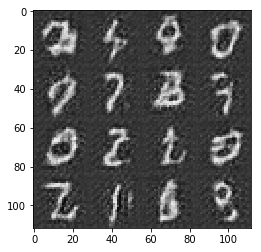

Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 3.2260
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.4058... Generator Loss: 1.4865
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 1.7705
Epoch 1/2... Discriminator Loss: 0.2593... Generator Loss: 2.2539
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 0.3698... Generator Loss: 1.6542
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 0.2206... Generator Loss: 1.9262


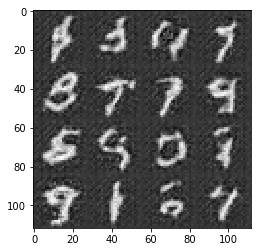

Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 3.6224
Epoch 1/2... Discriminator Loss: 0.1227... Generator Loss: 2.9794
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 0.2923... Generator Loss: 1.5585
Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 1.5996
Epoch 1/2... Discriminator Loss: 0.2219... Generator Loss: 1.9899
Epoch 1/2... Discriminator Loss: 0.1064... Generator Loss: 2.5680
Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.0390
Epoch 1/2... Discriminator Loss: 0.0458... Generator Loss: 3.8220


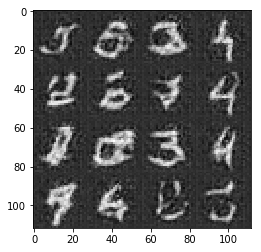

Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 1.2427
Epoch 1/2... Discriminator Loss: 0.0642... Generator Loss: 3.3377
Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 0.3024... Generator Loss: 1.6049
Epoch 1/2... Discriminator Loss: 0.0994... Generator Loss: 2.8254
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 3.2281
Epoch 1/2... Discriminator Loss: 0.4559... Generator Loss: 2.1650
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 2.4965
Epoch 1/2... Discriminator Loss: 0.1723... Generator Loss: 2.4012


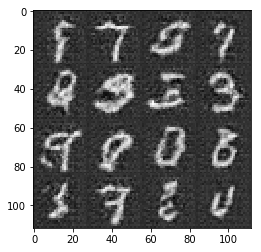

Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 1.5464
Epoch 1/2... Discriminator Loss: 0.1794... Generator Loss: 1.9732
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 0.1476... Generator Loss: 2.7086
Epoch 1/2... Discriminator Loss: 0.3228... Generator Loss: 1.5737
Epoch 1/2... Discriminator Loss: 0.1631... Generator Loss: 2.7558
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 0.1316... Generator Loss: 3.3475
Epoch 1/2... Discriminator Loss: 2.7042... Generator Loss: 3.6115


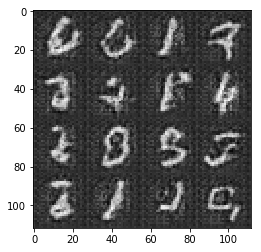

Epoch 1/2... Discriminator Loss: 0.2525... Generator Loss: 2.6907
Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 1.6923
Epoch 1/2... Discriminator Loss: 0.2612... Generator Loss: 1.8548
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 1.2900
Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 1.0427
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 4.3239
Epoch 1/2... Discriminator Loss: 0.0373... Generator Loss: 4.8170
Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 0.6917


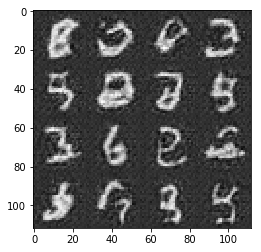

Epoch 1/2... Discriminator Loss: 0.2944... Generator Loss: 1.8966
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 4.6658
Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 1.9053
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 0.2587... Generator Loss: 1.8809
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 0.5814... Generator Loss: 4.7507
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.0735


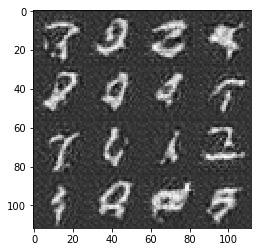

Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 3.0741
Epoch 1/2... Discriminator Loss: 0.6701... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 0.2134... Generator Loss: 2.1315
Epoch 1/2... Discriminator Loss: 0.0713... Generator Loss: 3.2750
Epoch 1/2... Discriminator Loss: 0.2344... Generator Loss: 2.4824
Epoch 1/2... Discriminator Loss: 0.0393... Generator Loss: 4.0964
Epoch 1/2... Discriminator Loss: 0.0381... Generator Loss: 3.9490
Epoch 1/2... Discriminator Loss: 0.2596... Generator Loss: 1.9066


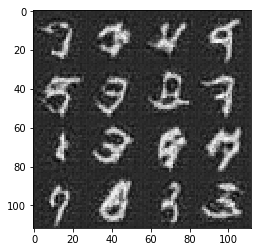

Epoch 1/2... Discriminator Loss: 0.0271... Generator Loss: 4.5053
Epoch 1/2... Discriminator Loss: 0.1325... Generator Loss: 2.4259
Epoch 1/2... Discriminator Loss: 0.0403... Generator Loss: 3.6699
Epoch 1/2... Discriminator Loss: 0.0460... Generator Loss: 3.3426
Epoch 1/2... Discriminator Loss: 0.1338... Generator Loss: 2.4982
Epoch 1/2... Discriminator Loss: 0.1046... Generator Loss: 2.6087
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.3095
Epoch 1/2... Discriminator Loss: 0.1513... Generator Loss: 3.0236
Epoch 1/2... Discriminator Loss: 0.0986... Generator Loss: 2.9837
Epoch 1/2... Discriminator Loss: 0.0296... Generator Loss: 5.1305


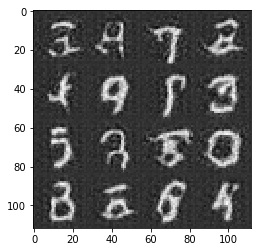

Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 3.4965
Epoch 1/2... Discriminator Loss: 6.1496... Generator Loss: 0.0058
Epoch 1/2... Discriminator Loss: 0.4983... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 0.1320... Generator Loss: 2.6349
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 3.4591
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 4.7884
Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 1.6810
Epoch 1/2... Discriminator Loss: 0.2944... Generator Loss: 1.7212
Epoch 1/2... Discriminator Loss: 0.3214... Generator Loss: 1.5215


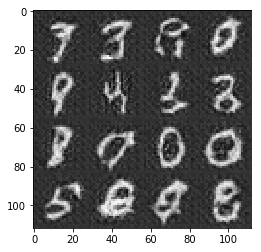

Epoch 1/2... Discriminator Loss: 0.4256... Generator Loss: 1.9398
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.6826
Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 0.2149... Generator Loss: 3.2022
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 1.5386
Epoch 1/2... Discriminator Loss: 0.0797... Generator Loss: 3.6273
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 2.4045
Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 0.3769... Generator Loss: 1.4219


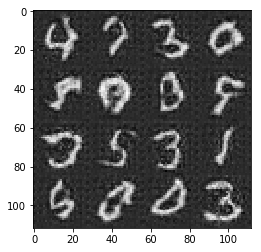

Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 1.6960
Epoch 1/2... Discriminator Loss: 0.0499... Generator Loss: 3.7020
Epoch 1/2... Discriminator Loss: 0.2493... Generator Loss: 2.4734
Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 3.6130
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 1.7555
Epoch 1/2... Discriminator Loss: 0.0522... Generator Loss: 3.2719
Epoch 1/2... Discriminator Loss: 0.0252... Generator Loss: 4.3141
Epoch 1/2... Discriminator Loss: 0.1093... Generator Loss: 2.5285
Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 1.7145
Epoch 1/2... Discriminator Loss: 5.6870... Generator Loss: 9.6085


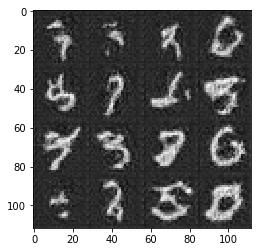

Epoch 1/2... Discriminator Loss: 0.0983... Generator Loss: 3.4373
Epoch 1/2... Discriminator Loss: 0.2970... Generator Loss: 1.9140
Epoch 1/2... Discriminator Loss: 0.1367... Generator Loss: 2.4505
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 4.2067
Epoch 1/2... Discriminator Loss: 0.2616... Generator Loss: 1.9050
Epoch 1/2... Discriminator Loss: 0.3031... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.3473
Epoch 1/2... Discriminator Loss: 0.2361... Generator Loss: 2.1909
Epoch 1/2... Discriminator Loss: 0.1302... Generator Loss: 3.1523
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.8057


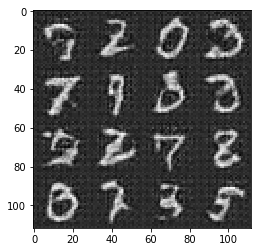

Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 1.5173
Epoch 1/2... Discriminator Loss: 0.2931... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 0.4682... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 0.3174... Generator Loss: 1.9420
Epoch 1/2... Discriminator Loss: 0.1332... Generator Loss: 2.5379
Epoch 1/2... Discriminator Loss: 0.2454... Generator Loss: 2.1427
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 4.4472
Epoch 1/2... Discriminator Loss: 0.1339... Generator Loss: 2.5559
Epoch 1/2... Discriminator Loss: 0.2467... Generator Loss: 1.9359


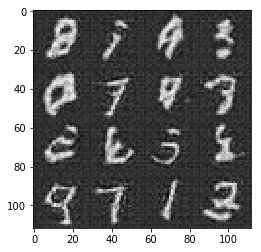

Epoch 1/2... Discriminator Loss: 0.0783... Generator Loss: 6.6446
Epoch 1/2... Discriminator Loss: 0.0404... Generator Loss: 5.6361
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 0.2698... Generator Loss: 1.7961
Epoch 1/2... Discriminator Loss: 0.0173... Generator Loss: 5.6341
Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 1.3528
Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 1.4035
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 2.5783
Epoch 1/2... Discriminator Loss: 0.1538... Generator Loss: 2.2761


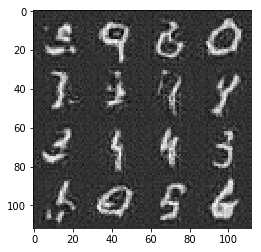

Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 2.7681
Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.3927
Epoch 1/2... Discriminator Loss: 0.1326... Generator Loss: 2.8687
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 3.7467
Epoch 1/2... Discriminator Loss: 0.4160... Generator Loss: 4.3376
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 1.5178
Epoch 1/2... Discriminator Loss: 0.2864... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.7137... Generator Loss: 4.8267
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.8522


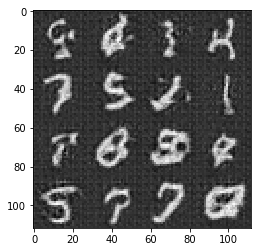

Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 1.3667
Epoch 1/2... Discriminator Loss: 0.4731... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 0.1332... Generator Loss: 2.9527
Epoch 1/2... Discriminator Loss: 0.6975... Generator Loss: 1.1395
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 0.8149... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.6039
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 0.4168... Generator Loss: 1.6136


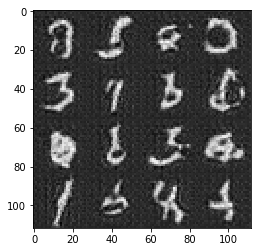

Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 0.1741... Generator Loss: 2.8363
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 0.1782... Generator Loss: 2.2018
Epoch 1/2... Discriminator Loss: 0.0089... Generator Loss: 7.0483
Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 2.3325
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 0.8582


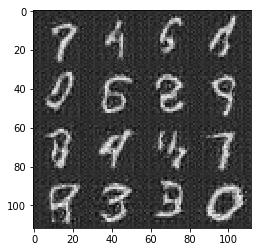

Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 3.1913
Epoch 1/2... Discriminator Loss: 0.2015... Generator Loss: 2.5426
Epoch 1/2... Discriminator Loss: 0.2687... Generator Loss: 2.1420
Epoch 1/2... Discriminator Loss: 0.1348... Generator Loss: 2.9646
Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 1.4680
Epoch 1/2... Discriminator Loss: 0.0887... Generator Loss: 3.1865
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 1.9755
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.3219
Epoch 1/2... Discriminator Loss: 0.1821... Generator Loss: 2.1702
Epoch 1/2... Discriminator Loss: 0.0323... Generator Loss: 4.0353


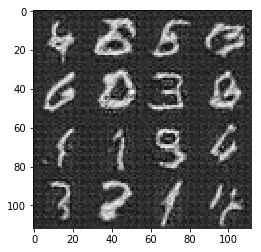

Epoch 1/2... Discriminator Loss: 0.2216... Generator Loss: 1.9458
Epoch 1/2... Discriminator Loss: 0.0406... Generator Loss: 3.8831
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.1563
Epoch 1/2... Discriminator Loss: 0.0641... Generator Loss: 3.4163
Epoch 1/2... Discriminator Loss: 0.1761... Generator Loss: 2.3369
Epoch 1/2... Discriminator Loss: 0.1165... Generator Loss: 6.3555
Epoch 1/2... Discriminator Loss: 2.7441... Generator Loss: 0.2372
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 0.2610... Generator Loss: 2.1742
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.2623


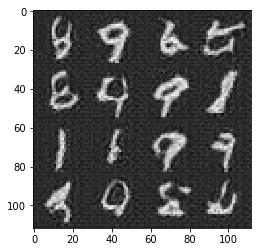

Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 1.7355
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.5937
Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 5.1099
Epoch 1/2... Discriminator Loss: 0.0942... Generator Loss: 3.2948
Epoch 1/2... Discriminator Loss: 0.3036... Generator Loss: 5.7641
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 0.1826... Generator Loss: 2.2731
Epoch 1/2... Discriminator Loss: 0.0928... Generator Loss: 3.1173
Epoch 1/2... Discriminator Loss: 0.1129... Generator Loss: 3.3437
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 0.7403


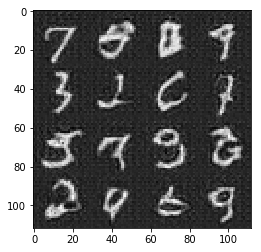

Epoch 1/2... Discriminator Loss: 0.1221... Generator Loss: 2.7281
Epoch 1/2... Discriminator Loss: 0.2316... Generator Loss: 1.8899
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 0.1939... Generator Loss: 2.3097
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 6.6162
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 0.3492
Epoch 1/2... Discriminator Loss: 0.4079... Generator Loss: 1.8865
Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 1.9386
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 7.0049
Epoch 1/2... Discriminator Loss: 2.8549... Generator Loss: 0.1167


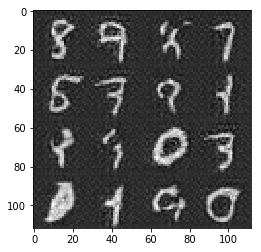

Epoch 1/2... Discriminator Loss: 0.3097... Generator Loss: 2.1042
Epoch 1/2... Discriminator Loss: 1.7294... Generator Loss: 0.2696
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.4679
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.2673
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 0.6038... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 0.2418... Generator Loss: 2.2039
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 3.5034


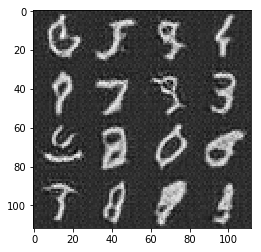

Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 3.3785
Epoch 1/2... Discriminator Loss: 0.0922... Generator Loss: 3.4495
Epoch 1/2... Discriminator Loss: 0.2931... Generator Loss: 1.7902
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 1.7229
Epoch 1/2... Discriminator Loss: 0.1015... Generator Loss: 3.6080
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 0.1333... Generator Loss: 2.6549
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 4.0890
Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 1.2854


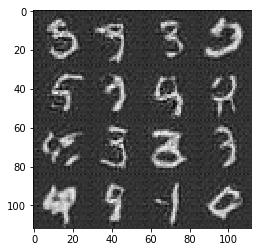

Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 0.1490... Generator Loss: 2.5159
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 1.7536
Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 5.0020
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 1.7907
Epoch 1/2... Discriminator Loss: 0.1596... Generator Loss: 2.4024


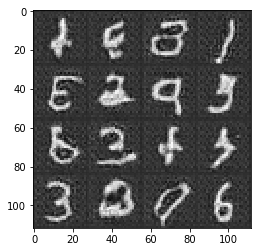

Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 1.1576
Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 1.2236
Epoch 1/2... Discriminator Loss: 0.1383... Generator Loss: 2.6657
Epoch 1/2... Discriminator Loss: 0.1841... Generator Loss: 2.9008
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 0.2208... Generator Loss: 1.7904
Epoch 1/2... Discriminator Loss: 0.3232... Generator Loss: 1.5525
Epoch 1/2... Discriminator Loss: 0.0647... Generator Loss: 3.5179
Epoch 1/2... Discriminator Loss: 5.6454... Generator Loss: 12.4671
Epoch 1/2... Discriminator Loss: 0.1816... Generator Loss: 4.2369


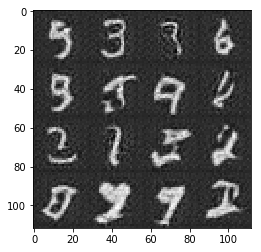

Epoch 1/2... Discriminator Loss: 0.2952... Generator Loss: 3.7029
Epoch 1/2... Discriminator Loss: 0.2801... Generator Loss: 7.1577
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 2.2306... Generator Loss: 0.1662
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 0.0595... Generator Loss: 3.7420
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 0.0320... Generator Loss: 4.0854
Epoch 1/2... Discriminator Loss: 0.1244... Generator Loss: 2.5451


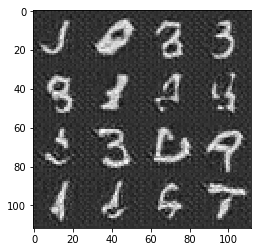

Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 0.0776... Generator Loss: 3.5022
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 2.5551
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 2.8524
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.2564... Generator Loss: 2.1758
Epoch 1/2... Discriminator Loss: 0.2345... Generator Loss: 4.9525
Epoch 1/2... Discriminator Loss: 0.1962... Generator Loss: 3.8909
Epoch 1/2... Discriminator Loss: 0.3212... Generator Loss: 1.6211


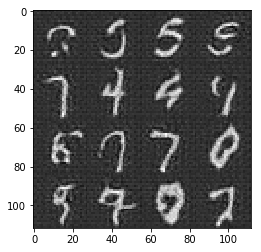

Epoch 1/2... Discriminator Loss: 0.2542... Generator Loss: 1.8285
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.3445
Epoch 1/2... Discriminator Loss: 0.1175... Generator Loss: 4.0521
Epoch 1/2... Discriminator Loss: 0.1974... Generator Loss: 2.4315
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 1.9856
Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 2.5618
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 0.1420... Generator Loss: 2.3907
Epoch 1/2... Discriminator Loss: 0.1598... Generator Loss: 2.5443


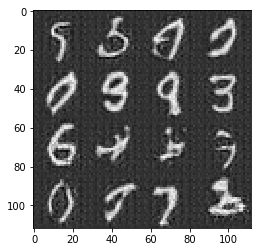

Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 1.8561
Epoch 1/2... Discriminator Loss: 0.3195... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 1.5563
Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 2.6230
Epoch 1/2... Discriminator Loss: 0.3094... Generator Loss: 2.7647
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 2.8130
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 0.0677... Generator Loss: 3.3823
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 0.5458... Generator Loss: 1.0653


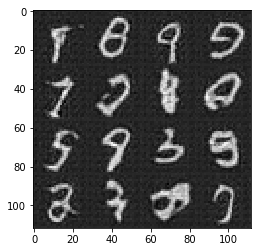

Epoch 1/2... Discriminator Loss: 0.5569... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 0.2277... Generator Loss: 2.3675
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 1.4312
Epoch 1/2... Discriminator Loss: 0.1086... Generator Loss: 2.5679
Epoch 1/2... Discriminator Loss: 0.0771... Generator Loss: 3.3376
Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 0.0544... Generator Loss: 3.4902


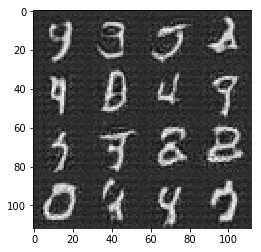

Epoch 1/2... Discriminator Loss: 0.3222... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 0.2797... Generator Loss: 1.6952
Epoch 1/2... Discriminator Loss: 0.0125... Generator Loss: 6.1560
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3097
Epoch 1/2... Discriminator Loss: 0.0445... Generator Loss: 4.2540
Epoch 1/2... Discriminator Loss: 0.0496... Generator Loss: 3.6453
Epoch 1/2... Discriminator Loss: 0.3202... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 1.8644
Epoch 1/2... Discriminator Loss: 0.0765... Generator Loss: 3.3861
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 1.8573


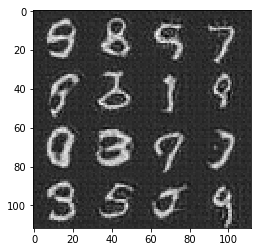

Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 0.0651... Generator Loss: 3.4796
Epoch 1/2... Discriminator Loss: 0.1485... Generator Loss: 2.3024
Epoch 1/2... Discriminator Loss: 0.0558... Generator Loss: 3.7988
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 0.1531... Generator Loss: 2.7354
Epoch 1/2... Discriminator Loss: 0.0230... Generator Loss: 4.8770
Epoch 1/2... Discriminator Loss: 0.0260... Generator Loss: 6.2391
Epoch 1/2... Discriminator Loss: 0.2586... Generator Loss: 2.4548
Epoch 1/2... Discriminator Loss: 0.1215... Generator Loss: 3.9811


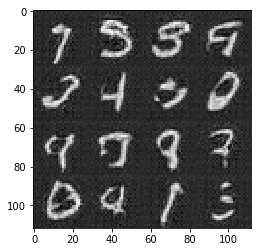

Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 0.4279... Generator Loss: 1.6390
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 0.2571... Generator Loss: 2.0726
Epoch 1/2... Discriminator Loss: 0.1640... Generator Loss: 2.3783
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 3.5185... Generator Loss: 0.0431
Epoch 1/2... Discriminator Loss: 0.1992... Generator Loss: 3.4058
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 1.9923


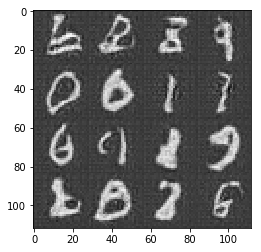

Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 5.2350
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 0.2118... Generator Loss: 2.5270
Epoch 1/2... Discriminator Loss: 0.2250... Generator Loss: 1.8512
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 0.0361... Generator Loss: 3.9606
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 2.3467
Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 1.8918


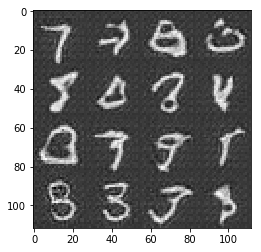

Epoch 1/2... Discriminator Loss: 0.0661... Generator Loss: 3.4921
Epoch 1/2... Discriminator Loss: 0.2844... Generator Loss: 1.6613
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.6166
Epoch 1/2... Discriminator Loss: 0.4576... Generator Loss: 1.4587
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 1.1038
Epoch 1/2... Discriminator Loss: 0.0486... Generator Loss: 4.1687
Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 3.0329
Epoch 1/2... Discriminator Loss: 0.2685... Generator Loss: 2.3515
Epoch 1/2... Discriminator Loss: 0.2915... Generator Loss: 1.9345
Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 1.4593


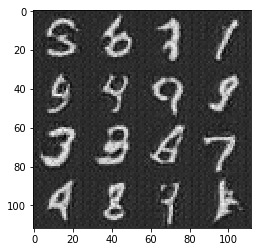

Epoch 1/2... Discriminator Loss: 0.1738... Generator Loss: 2.6577
Epoch 1/2... Discriminator Loss: 1.8225... Generator Loss: 7.5244
Epoch 1/2... Discriminator Loss: 0.7034... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 2.7968... Generator Loss: 0.2660
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 4.5999
Epoch 1/2... Discriminator Loss: 0.2982... Generator Loss: 2.1590
Epoch 1/2... Discriminator Loss: 0.1212... Generator Loss: 2.7414
Epoch 1/2... Discriminator Loss: 0.3161... Generator Loss: 2.2249
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 0.8187... Generator Loss: 0.7880


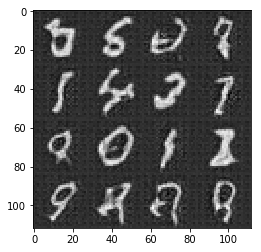

Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 3.9479
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 0.2745... Generator Loss: 1.9459
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 0.2869... Generator Loss: 1.6178
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 1.6522
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 0.1180... Generator Loss: 2.5874
Epoch 1/2... Discriminator Loss: 0.2599... Generator Loss: 2.8325


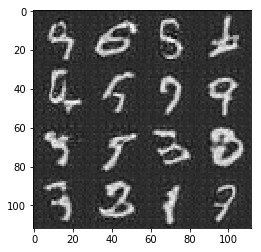

Epoch 2/2... Discriminator Loss: 1.7502... Generator Loss: 0.2505
Epoch 2/2... Discriminator Loss: 0.2753... Generator Loss: 2.6937
Epoch 2/2... Discriminator Loss: 0.1311... Generator Loss: 2.7330
Epoch 2/2... Discriminator Loss: 0.1476... Generator Loss: 3.3215
Epoch 2/2... Discriminator Loss: 0.1857... Generator Loss: 2.4734
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 0.0785... Generator Loss: 3.2720
Epoch 2/2... Discriminator Loss: 0.4451... Generator Loss: 1.4051
Epoch 2/2... Discriminator Loss: 0.0345... Generator Loss: 3.9657
Epoch 2/2... Discriminator Loss: 0.2268... Generator Loss: 2.4553


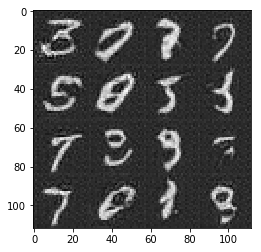

Epoch 2/2... Discriminator Loss: 0.2529... Generator Loss: 2.1871
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.6333
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 2.7857
Epoch 2/2... Discriminator Loss: 1.8632... Generator Loss: 0.2537
Epoch 2/2... Discriminator Loss: 0.1758... Generator Loss: 2.4109
Epoch 2/2... Discriminator Loss: 0.1903... Generator Loss: 2.1832
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.0521... Generator Loss: 3.1928
Epoch 2/2... Discriminator Loss: 0.2647... Generator Loss: 1.7449
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.7036


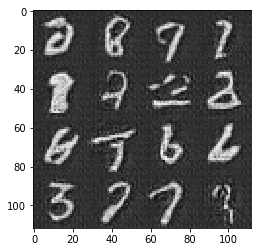

Epoch 2/2... Discriminator Loss: 0.2516... Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 0.4744... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 0.3043... Generator Loss: 3.1044
Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 1.5649
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 0.9620
Epoch 2/2... Discriminator Loss: 0.2405... Generator Loss: 1.8615
Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 4.6573
Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 1.8623
Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 1.4838


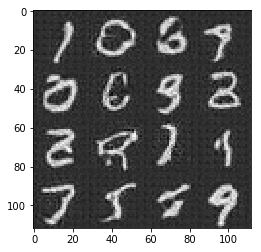

Epoch 2/2... Discriminator Loss: 0.2311... Generator Loss: 2.5108
Epoch 2/2... Discriminator Loss: 1.9611... Generator Loss: 0.2102
Epoch 2/2... Discriminator Loss: 0.4189... Generator Loss: 1.6446
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 0.0442... Generator Loss: 3.4548
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 0.1804... Generator Loss: 2.3440
Epoch 2/2... Discriminator Loss: 0.0112... Generator Loss: 6.8459
Epoch 2/2... Discriminator Loss: 0.1322... Generator Loss: 2.4013


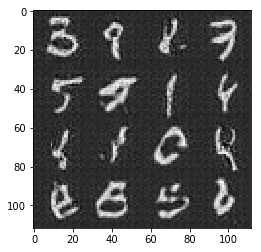

Epoch 2/2... Discriminator Loss: 0.0985... Generator Loss: 3.0724
Epoch 2/2... Discriminator Loss: 0.1227... Generator Loss: 2.6213
Epoch 2/2... Discriminator Loss: 0.2781... Generator Loss: 1.6845
Epoch 2/2... Discriminator Loss: 0.0953... Generator Loss: 2.7891
Epoch 2/2... Discriminator Loss: 0.2091... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 0.0570... Generator Loss: 3.4824
Epoch 2/2... Discriminator Loss: 0.1012... Generator Loss: 2.7858
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.1412... Generator Loss: 3.0746
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 0.4691


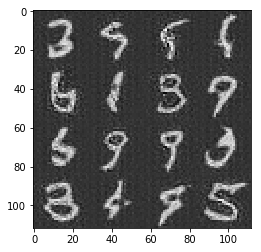

Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 1.5981
Epoch 2/2... Discriminator Loss: 0.0272... Generator Loss: 5.1409
Epoch 2/2... Discriminator Loss: 0.1160... Generator Loss: 2.9569
Epoch 2/2... Discriminator Loss: 0.2057... Generator Loss: 2.6124
Epoch 2/2... Discriminator Loss: 0.0484... Generator Loss: 3.9461
Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 1.6972
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 1.8677
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 2.3139
Epoch 2/2... Discriminator Loss: 1.9545... Generator Loss: 0.2231
Epoch 2/2... Discriminator Loss: 0.0662... Generator Loss: 3.2420


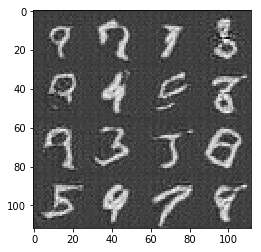

Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 1.7617
Epoch 2/2... Discriminator Loss: 0.4738... Generator Loss: 1.7573
Epoch 2/2... Discriminator Loss: 0.2583... Generator Loss: 2.7588
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 3.1070
Epoch 2/2... Discriminator Loss: 0.0999... Generator Loss: 3.2879
Epoch 2/2... Discriminator Loss: 0.1968... Generator Loss: 1.9515
Epoch 2/2... Discriminator Loss: 0.1416... Generator Loss: 3.7744
Epoch 2/2... Discriminator Loss: 0.1512... Generator Loss: 3.1010
Epoch 2/2... Discriminator Loss: 0.0633... Generator Loss: 3.8658
Epoch 2/2... Discriminator Loss: 0.2947... Generator Loss: 1.8016


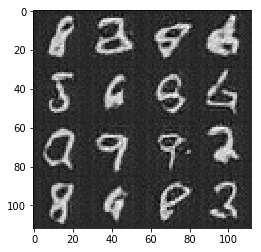

Epoch 2/2... Discriminator Loss: 0.2766... Generator Loss: 2.1293
Epoch 2/2... Discriminator Loss: 0.0386... Generator Loss: 4.3202
Epoch 2/2... Discriminator Loss: 0.3048... Generator Loss: 1.6836
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 0.1827... Generator Loss: 2.5366
Epoch 2/2... Discriminator Loss: 0.2055... Generator Loss: 2.3512
Epoch 2/2... Discriminator Loss: 0.0614... Generator Loss: 3.4256
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 5.2457
Epoch 2/2... Discriminator Loss: 2.2347... Generator Loss: 8.0515
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 1.8773


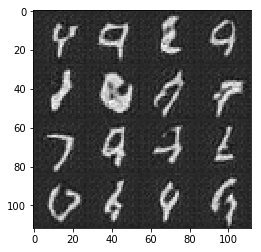

Epoch 2/2... Discriminator Loss: 1.5939... Generator Loss: 0.3159
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 0.2296... Generator Loss: 1.9734
Epoch 2/2... Discriminator Loss: 0.1558... Generator Loss: 3.2292
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 0.1973... Generator Loss: 2.1938
Epoch 2/2... Discriminator Loss: 0.1549... Generator Loss: 3.5182
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.4228
Epoch 2/2... Discriminator Loss: 0.0137... Generator Loss: 5.3676
Epoch 2/2... Discriminator Loss: 0.0750... Generator Loss: 3.0690


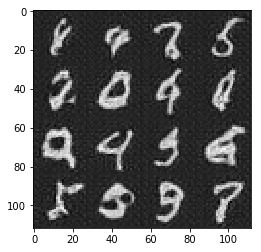

Epoch 2/2... Discriminator Loss: 0.5346... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 1.5157
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 0.2364... Generator Loss: 2.2651
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 0.3022... Generator Loss: 2.4806
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 0.2627... Generator Loss: 2.6181
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.4605


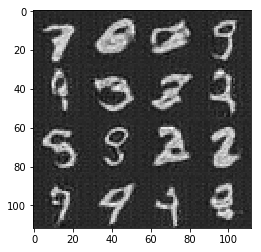

Epoch 2/2... Discriminator Loss: 0.3479... Generator Loss: 2.0778
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 1.9208
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 1.4893
Epoch 2/2... Discriminator Loss: 0.0955... Generator Loss: 3.5558
Epoch 2/2... Discriminator Loss: 0.0436... Generator Loss: 3.9240
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.4642
Epoch 2/2... Discriminator Loss: 0.2593... Generator Loss: 1.7300


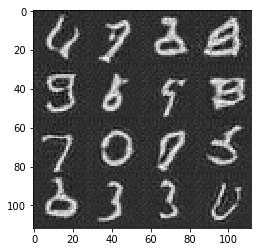

Epoch 2/2... Discriminator Loss: 0.2118... Generator Loss: 3.8710
Epoch 2/2... Discriminator Loss: 0.3194... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.3192
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 1.9341
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 0.2854... Generator Loss: 1.7010
Epoch 2/2... Discriminator Loss: 0.1076... Generator Loss: 3.0099
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 1.0760


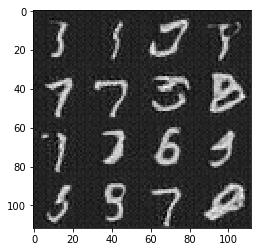

Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 1.2250
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.8788
Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 1.6712
Epoch 2/2... Discriminator Loss: 0.1502... Generator Loss: 2.7131
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 1.4466
Epoch 2/2... Discriminator Loss: 0.0938... Generator Loss: 3.2025
Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 2.3497
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.5251
Epoch 2/2... Discriminator Loss: 0.4468... Generator Loss: 2.2470


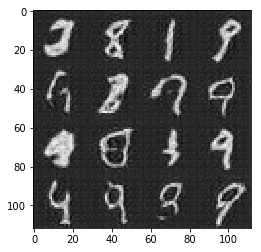

Epoch 2/2... Discriminator Loss: 0.4889... Generator Loss: 1.6808
Epoch 2/2... Discriminator Loss: 0.2407... Generator Loss: 6.0756
Epoch 2/2... Discriminator Loss: 0.2780... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.0848... Generator Loss: 2.7600
Epoch 2/2... Discriminator Loss: 0.0181... Generator Loss: 4.6854
Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.2886
Epoch 2/2... Discriminator Loss: 0.0393... Generator Loss: 3.9704
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 0.0110... Generator Loss: 5.2120
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.0066


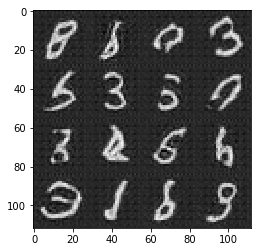

Epoch 2/2... Discriminator Loss: 0.0803... Generator Loss: 3.4039
Epoch 2/2... Discriminator Loss: 0.0267... Generator Loss: 4.6791
Epoch 2/2... Discriminator Loss: 0.1709... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 6.5986
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 2.2243
Epoch 2/2... Discriminator Loss: 0.0239... Generator Loss: 4.0874
Epoch 2/2... Discriminator Loss: 0.1718... Generator Loss: 2.3086
Epoch 2/2... Discriminator Loss: 0.0658... Generator Loss: 3.5770
Epoch 2/2... Discriminator Loss: 0.2896... Generator Loss: 1.5051
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.0916


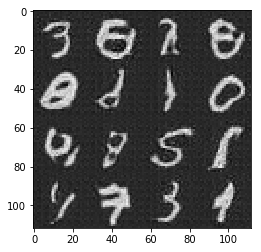

Epoch 2/2... Discriminator Loss: 0.2783... Generator Loss: 1.8422
Epoch 2/2... Discriminator Loss: 0.0863... Generator Loss: 2.8709
Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 4.7314
Epoch 2/2... Discriminator Loss: 0.1326... Generator Loss: 2.3188
Epoch 2/2... Discriminator Loss: 0.0855... Generator Loss: 3.1423
Epoch 2/2... Discriminator Loss: 0.0731... Generator Loss: 3.6133
Epoch 2/2... Discriminator Loss: 0.3883... Generator Loss: 1.7645
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 0.0306... Generator Loss: 3.9653
Epoch 2/2... Discriminator Loss: 0.2365... Generator Loss: 2.2189


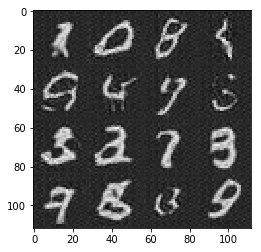

Epoch 2/2... Discriminator Loss: 0.2429... Generator Loss: 2.1170
Epoch 2/2... Discriminator Loss: 0.1649... Generator Loss: 2.3573
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 0.6145
Epoch 2/2... Discriminator Loss: 0.4380... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 3.0807
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.2595
Epoch 2/2... Discriminator Loss: 0.1185... Generator Loss: 2.6893
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.1286... Generator Loss: 2.8027
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 3.5207


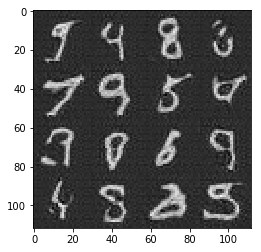

Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.6707
Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 2.2112
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.8178
Epoch 2/2... Discriminator Loss: 0.0878... Generator Loss: 3.3474
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.3766
Epoch 2/2... Discriminator Loss: 0.1126... Generator Loss: 4.9413
Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 1.9628
Epoch 2/2... Discriminator Loss: 1.7403... Generator Loss: 0.3583
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.9881


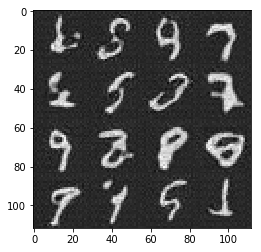

Epoch 2/2... Discriminator Loss: 0.2110... Generator Loss: 2.7333
Epoch 2/2... Discriminator Loss: 0.1165... Generator Loss: 3.1869
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 0.1690... Generator Loss: 2.1698
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.3344
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 0.2715... Generator Loss: 1.8889
Epoch 2/2... Discriminator Loss: 0.1677... Generator Loss: 2.3134
Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.3177


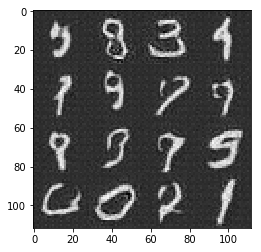

Epoch 2/2... Discriminator Loss: 0.4602... Generator Loss: 1.3943
Epoch 2/2... Discriminator Loss: 1.6749... Generator Loss: 0.2929
Epoch 2/2... Discriminator Loss: 0.4310... Generator Loss: 1.9995
Epoch 2/2... Discriminator Loss: 0.1457... Generator Loss: 3.2771
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 6.1755
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 3.0287
Epoch 2/2... Discriminator Loss: 0.0417... Generator Loss: 4.1901
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 2.7221
Epoch 2/2... Discriminator Loss: 0.0355... Generator Loss: 3.8198
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 1.2201


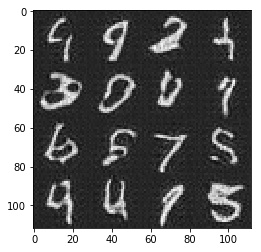

Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 0.4043... Generator Loss: 1.5448
Epoch 2/2... Discriminator Loss: 0.2913... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 0.3878... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 4.3707
Epoch 2/2... Discriminator Loss: 0.1818... Generator Loss: 2.5497
Epoch 2/2... Discriminator Loss: 0.0571... Generator Loss: 3.4083
Epoch 2/2... Discriminator Loss: 0.0162... Generator Loss: 4.5263
Epoch 2/2... Discriminator Loss: 0.2226... Generator Loss: 1.9874


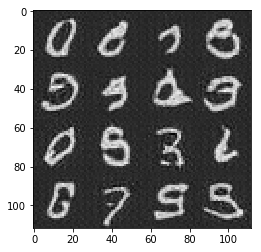

Epoch 2/2... Discriminator Loss: 0.3175... Generator Loss: 2.2706
Epoch 2/2... Discriminator Loss: 0.0266... Generator Loss: 4.3731
Epoch 2/2... Discriminator Loss: 0.2097... Generator Loss: 2.0365
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 4.0336
Epoch 2/2... Discriminator Loss: 0.3447... Generator Loss: 2.3098
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 1.8846
Epoch 2/2... Discriminator Loss: 0.2894... Generator Loss: 1.9952
Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.2623... Generator Loss: 1.7824


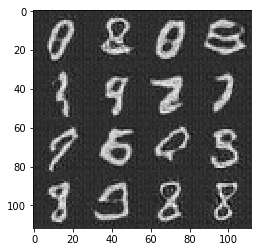

Epoch 2/2... Discriminator Loss: 0.1298... Generator Loss: 2.4741
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 0.1391... Generator Loss: 2.8373
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 0.2557... Generator Loss: 2.3470
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 1.9863
Epoch 2/2... Discriminator Loss: 0.1071... Generator Loss: 2.5557
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 1.3998
Epoch 2/2... Discriminator Loss: 0.3683... Generator Loss: 1.9622
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.9270


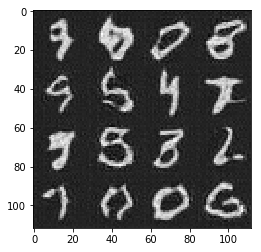

Epoch 2/2... Discriminator Loss: 0.1505... Generator Loss: 2.2521
Epoch 2/2... Discriminator Loss: 2.2088... Generator Loss: 0.2000
Epoch 2/2... Discriminator Loss: 0.1608... Generator Loss: 3.1674
Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 1.9173
Epoch 2/2... Discriminator Loss: 0.1037... Generator Loss: 3.2511
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 2.6661
Epoch 2/2... Discriminator Loss: 0.2311... Generator Loss: 2.3827
Epoch 2/2... Discriminator Loss: 0.5019... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.5250


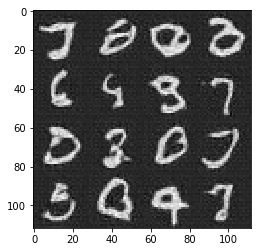

Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 0.2157... Generator Loss: 2.2408
Epoch 2/2... Discriminator Loss: 0.3183... Generator Loss: 2.0332
Epoch 2/2... Discriminator Loss: 0.7168... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 1.6967
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.5541
Epoch 2/2... Discriminator Loss: 0.3367... Generator Loss: 1.7662
Epoch 2/2... Discriminator Loss: 0.2180... Generator Loss: 2.0507


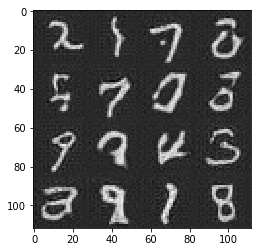

Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 0.2043... Generator Loss: 2.2140
Epoch 2/2... Discriminator Loss: 0.3130... Generator Loss: 1.8510
Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 0.4444... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.0622... Generator Loss: 3.1346
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 0.1481... Generator Loss: 2.1028
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 0.8177


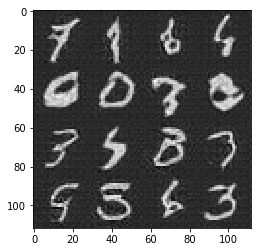

Epoch 2/2... Discriminator Loss: 0.1283... Generator Loss: 2.4197
Epoch 2/2... Discriminator Loss: 0.0224... Generator Loss: 4.2747
Epoch 2/2... Discriminator Loss: 0.0604... Generator Loss: 3.3767
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 0.2663... Generator Loss: 1.8750
Epoch 2/2... Discriminator Loss: 0.0683... Generator Loss: 3.0387
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.1163... Generator Loss: 3.1722
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 1.1632


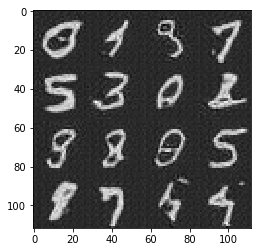

Epoch 2/2... Discriminator Loss: 0.2575... Generator Loss: 1.7719
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 1.5518
Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 0.2039... Generator Loss: 2.7316
Epoch 2/2... Discriminator Loss: 0.1167... Generator Loss: 2.8059
Epoch 2/2... Discriminator Loss: 0.1598... Generator Loss: 2.1566
Epoch 2/2... Discriminator Loss: 2.0868... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 7.0319
Epoch 2/2... Discriminator Loss: 0.3205... Generator Loss: 2.1330
Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.6696


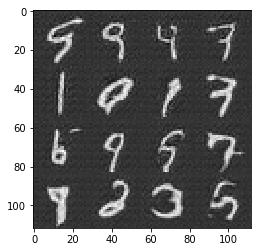

Epoch 2/2... Discriminator Loss: 0.3169... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.1606... Generator Loss: 2.4516
Epoch 2/2... Discriminator Loss: 0.1351... Generator Loss: 2.6553
Epoch 2/2... Discriminator Loss: 0.3551... Generator Loss: 2.0500
Epoch 2/2... Discriminator Loss: 0.0926... Generator Loss: 3.1909
Epoch 2/2... Discriminator Loss: 0.2980... Generator Loss: 1.8582
Epoch 2/2... Discriminator Loss: 0.2341... Generator Loss: 1.9386
Epoch 2/2... Discriminator Loss: 0.0675... Generator Loss: 3.2640
Epoch 2/2... Discriminator Loss: 0.1003... Generator Loss: 3.1441
Epoch 2/2... Discriminator Loss: 0.1115... Generator Loss: 2.6945


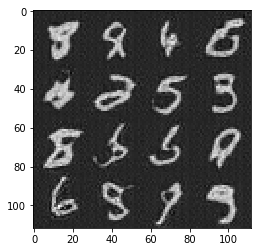

Epoch 2/2... Discriminator Loss: 0.1587... Generator Loss: 2.4168
Epoch 2/2... Discriminator Loss: 0.1476... Generator Loss: 2.1737
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 3.3906
Epoch 2/2... Discriminator Loss: 0.1335... Generator Loss: 2.3612
Epoch 2/2... Discriminator Loss: 0.0094... Generator Loss: 7.1777
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 1.4669
Epoch 2/2... Discriminator Loss: 0.2484... Generator Loss: 2.2983


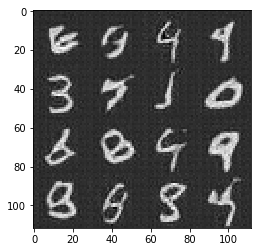

Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 0.2897... Generator Loss: 4.0000
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 3.8440
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 0.1879... Generator Loss: 2.3760
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 1.5839
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 0.7679


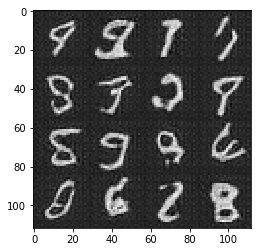

Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 1.5358
Epoch 2/2... Discriminator Loss: 2.1148... Generator Loss: 0.2489
Epoch 2/2... Discriminator Loss: 0.1804... Generator Loss: 2.5094
Epoch 2/2... Discriminator Loss: 0.1044... Generator Loss: 3.6890
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 0.7536
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 0.2508... Generator Loss: 2.2954
Epoch 2/2... Discriminator Loss: 2.0952... Generator Loss: 0.3145
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 1.8001


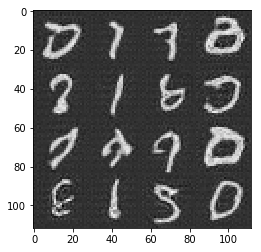

Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 2.8088... Generator Loss: 0.1035
Epoch 2/2... Discriminator Loss: 0.4260... Generator Loss: 1.4701
Epoch 2/2... Discriminator Loss: 0.4478... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 2.1463
Epoch 2/2... Discriminator Loss: 0.1603... Generator Loss: 2.2795
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 1.3271
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 2.0637
Epoch 2/2... Discriminator Loss: 0.1479... Generator Loss: 2.6134


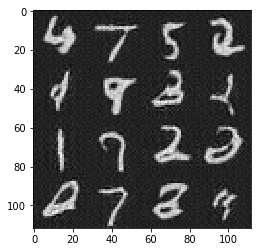

Epoch 2/2... Discriminator Loss: 0.2683... Generator Loss: 1.7044
Epoch 2/2... Discriminator Loss: 0.2024... Generator Loss: 1.9953
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.3938
Epoch 2/2... Discriminator Loss: 0.2301... Generator Loss: 1.7896
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 0.1491... Generator Loss: 2.2625
Epoch 2/2... Discriminator Loss: 0.1981... Generator Loss: 1.8671
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 2.3985
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 3.8078


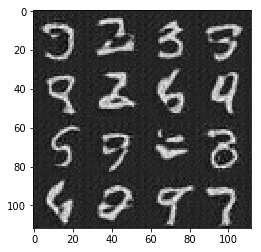

Epoch 2/2... Discriminator Loss: 0.2435... Generator Loss: 4.2754
Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 2.2140
Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 1.7748
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 1.3599
Epoch 2/2... Discriminator Loss: 0.0827... Generator Loss: 2.9650
Epoch 2/2... Discriminator Loss: 0.2933... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 0.1513... Generator Loss: 2.5733
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.0725
Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.5707


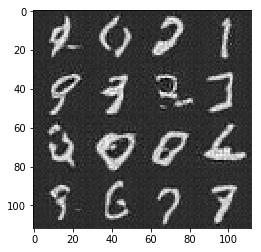

Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 1.4154
Epoch 2/2... Discriminator Loss: 0.1315... Generator Loss: 2.6612
Epoch 2/2... Discriminator Loss: 0.3002... Generator Loss: 2.1087
Epoch 2/2... Discriminator Loss: 0.1992... Generator Loss: 2.1116
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 2.7526... Generator Loss: 0.1972
Epoch 2/2... Discriminator Loss: 0.1906... Generator Loss: 2.4617
Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 0.9635


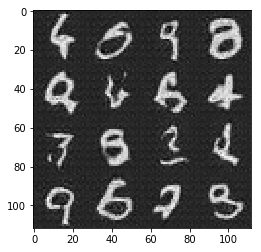

Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 4.1214
Epoch 2/2... Discriminator Loss: 0.3810... Generator Loss: 1.6486
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 1.3526
Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 1.8491
Epoch 2/2... Discriminator Loss: 3.8134... Generator Loss: 0.0477
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.1187
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 0.2265... Generator Loss: 2.2957
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 0.8057


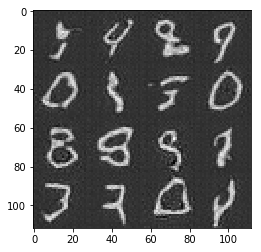

Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.1586... Generator Loss: 4.0327
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.4230
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 0.0668... Generator Loss: 3.8046
Epoch 2/2... Discriminator Loss: 2.4111... Generator Loss: 0.1314
Epoch 2/2... Discriminator Loss: 0.1827... Generator Loss: 2.1069
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.5825


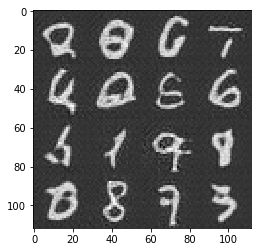

Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 0.3753... Generator Loss: 1.4441
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 5.5149
Epoch 2/2... Discriminator Loss: 0.1216... Generator Loss: 3.5766
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 2.6935
Epoch 2/2... Discriminator Loss: 0.1984... Generator Loss: 2.2108


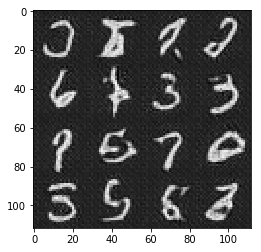

Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.4129
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 0.2604... Generator Loss: 2.1585
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 1.5505... Generator Loss: 0.4777
Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 1.4534
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.2409


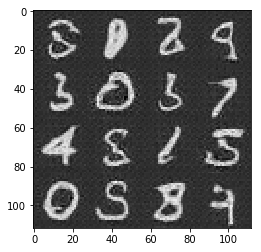

Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 4.3866
Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 2.6105
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 0.4519... Generator Loss: 1.5454
Epoch 2/2... Discriminator Loss: 0.2211... Generator Loss: 2.2392
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.1508
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 0.0842... Generator Loss: 3.3234


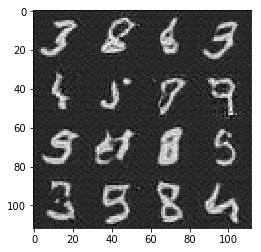

Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 1.7318
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 1.6112
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 1.5091
Epoch 2/2... Discriminator Loss: 0.1804... Generator Loss: 2.6105
Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 1.9081
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 2.9415
Epoch 2/2... Discriminator Loss: 0.0127... Generator Loss: 5.6910
Epoch 2/2... Discriminator Loss: 0.1363... Generator Loss: 3.2297
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 3.9648


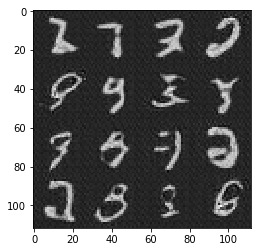

Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 4.0868
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 3.6306
Epoch 2/2... Discriminator Loss: 0.1100... Generator Loss: 3.3512
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 2.4297
Epoch 2/2... Discriminator Loss: 0.0359... Generator Loss: 4.1806
Epoch 2/2... Discriminator Loss: 0.5296... Generator Loss: 1.3867
Epoch 2/2... Discriminator Loss: 0.0681... Generator Loss: 3.3821
Epoch 2/2... Discriminator Loss: 0.0857... Generator Loss: 2.9146
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.5166


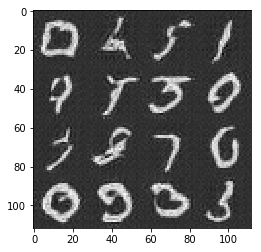

Epoch 2/2... Discriminator Loss: 0.1405... Generator Loss: 2.5662
Epoch 2/2... Discriminator Loss: 0.0140... Generator Loss: 6.7020
Epoch 2/2... Discriminator Loss: 0.0528... Generator Loss: 4.2703
Epoch 2/2... Discriminator Loss: 0.4091... Generator Loss: 2.1350
Epoch 2/2... Discriminator Loss: 0.2464... Generator Loss: 5.6589
Epoch 2/2... Discriminator Loss: 0.0440... Generator Loss: 5.1741
Epoch 2/2... Discriminator Loss: 0.1745... Generator Loss: 3.4256
Epoch 2/2... Discriminator Loss: 0.4928... Generator Loss: 1.5564
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 2.5935... Generator Loss: 0.1893


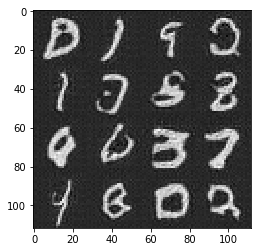

Epoch 2/2... Discriminator Loss: 0.1763... Generator Loss: 2.5640
Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.6483
Epoch 2/2... Discriminator Loss: 0.0755... Generator Loss: 5.7793
Epoch 2/2... Discriminator Loss: 0.2839... Generator Loss: 1.8544
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 0.2488... Generator Loss: 2.1463
Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 1.1911
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.5163
Epoch 2/2... Discriminator Loss: 0.2466... Generator Loss: 2.0651
Epoch 2/2... Discriminator Loss: 2.0018... Generator Loss: 0.3274


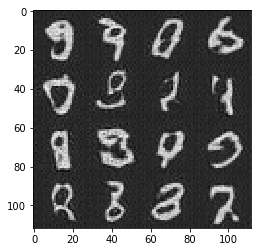

Epoch 2/2... Discriminator Loss: 0.3192... Generator Loss: 2.3094
Epoch 2/2... Discriminator Loss: 0.1221... Generator Loss: 3.3533
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.3027... Generator Loss: 1.9438
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 1.8593... Generator Loss: 0.3089
Epoch 2/2... Discriminator Loss: 0.4270... Generator Loss: 1.6340
Epoch 2/2... Discriminator Loss: 0.2379... Generator Loss: 3.3255
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 1.7705
Epoch 2/2... Discriminator Loss: 2.7539... Generator Loss: 0.1280


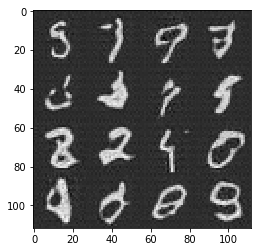

Epoch 2/2... Discriminator Loss: 0.2958... Generator Loss: 3.3395
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 1.7082
Epoch 2/2... Discriminator Loss: 0.2581... Generator Loss: 2.3756
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.7161
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 1.8712
Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 1.4799
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 2.1944
Epoch 2/2... Discriminator Loss: 0.3231... Generator Loss: 1.8924


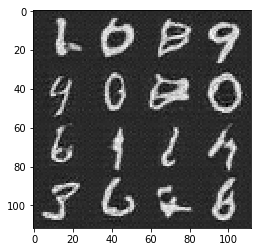

Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.2529... Generator Loss: 2.6990
Epoch 2/2... Discriminator Loss: 1.9203... Generator Loss: 0.4531
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 1.7913... Generator Loss: 0.2446
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 0.0738... Generator Loss: 4.1218
Epoch 2/2... Discriminator Loss: 0.1314... Generator Loss: 2.5213
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.4686
Epoch 2/2... Discriminator Loss: 0.5425... Generator Loss: 1.2295


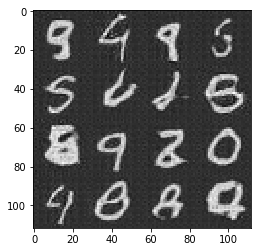

Epoch 2/2... Discriminator Loss: 0.1735... Generator Loss: 2.4088
Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 2.1087... Generator Loss: 0.2040
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.3291
Epoch 2/2... Discriminator Loss: 1.6986... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 0.9717
Epoch 2/2... Discriminator Loss: 0.0986... Generator Loss: 3.5729
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 0.1856... Generator Loss: 2.5337


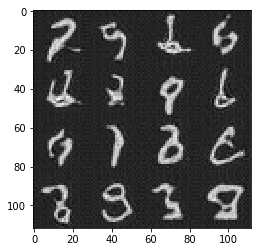

Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 0.0899... Generator Loss: 4.7040
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.4587
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 1.6028
Epoch 2/2... Discriminator Loss: 0.2853... Generator Loss: 2.1447
Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 1.2564
Epoch 2/2... Discriminator Loss: 0.2781... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 0.0786... Generator Loss: 4.4522


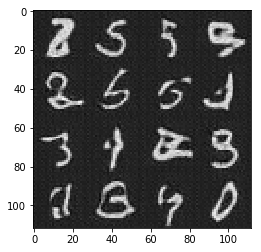

Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 0.1025... Generator Loss: 2.9820
Epoch 2/2... Discriminator Loss: 0.1867... Generator Loss: 2.1789
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 0.8702
Epoch 2/2... Discriminator Loss: 0.0760... Generator Loss: 3.6247
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 1.7691
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 4.7527
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 1.4511


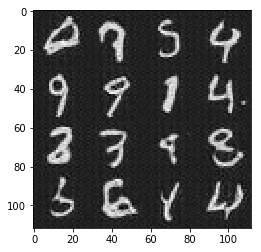

Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.0363
Epoch 2/2... Discriminator Loss: 0.0630... Generator Loss: 3.6901
Epoch 2/2... Discriminator Loss: 0.0918... Generator Loss: 3.1093
Epoch 2/2... Discriminator Loss: 0.1634... Generator Loss: 3.5466
Epoch 2/2... Discriminator Loss: 2.6887... Generator Loss: 0.1650
Epoch 2/2... Discriminator Loss: 0.1572... Generator Loss: 2.5926
Epoch 2/2... Discriminator Loss: 0.4709... Generator Loss: 1.4321
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 5.2217
Epoch 2/2... Discriminator Loss: 0.0260... Generator Loss: 4.2821
Epoch 2/2... Discriminator Loss: 0.4568... Generator Loss: 1.6896


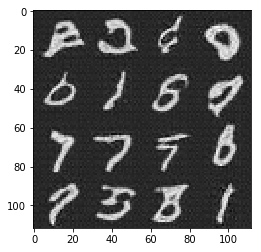

Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 0.0072... Generator Loss: 6.0355
Epoch 2/2... Discriminator Loss: 0.0493... Generator Loss: 3.4848
Epoch 2/2... Discriminator Loss: 0.3126... Generator Loss: 1.4359
Epoch 2/2... Discriminator Loss: 0.4659... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 0.2439... Generator Loss: 1.8523
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 0.1328... Generator Loss: 2.4327
Epoch 2/2... Discriminator Loss: 0.1780... Generator Loss: 2.5563
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 3.6714


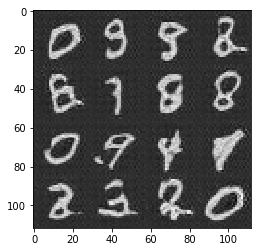

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 4.2706
Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.2470
Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.3857
Epoch 2/2... Discriminator Loss: 0.1376... Generator Loss: 2.5815
Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.3016... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 3.0702
Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 1.1919


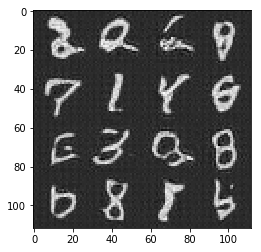

Epoch 2/2... Discriminator Loss: 0.0296... Generator Loss: 4.7051
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 0.0496... Generator Loss: 4.3300
Epoch 2/2... Discriminator Loss: 0.3948... Generator Loss: 1.7722
Epoch 2/2... Discriminator Loss: 0.0572... Generator Loss: 3.3932
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 1.8756
Epoch 2/2... Discriminator Loss: 0.0693... Generator Loss: 3.2762
Epoch 2/2... Discriminator Loss: 0.0985... Generator Loss: 3.2609
Epoch 2/2... Discriminator Loss: 0.2011... Generator Loss: 2.0861
Epoch 2/2... Discriminator Loss: 0.0750... Generator Loss: 3.2153


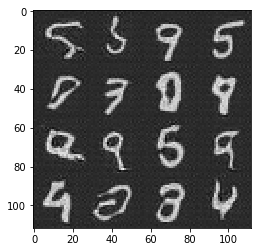

Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.3210
Epoch 2/2... Discriminator Loss: 0.3266... Generator Loss: 1.5501
Epoch 2/2... Discriminator Loss: 0.0962... Generator Loss: 2.6991
Epoch 2/2... Discriminator Loss: 0.0298... Generator Loss: 4.6549
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.3887
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 4.6191
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.0858... Generator Loss: 3.6961
Epoch 2/2... Discriminator Loss: 0.3149... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 1.7476


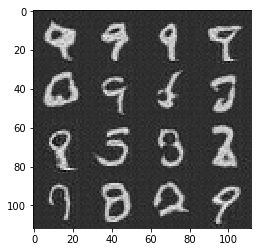

Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 0.0893... Generator Loss: 3.4569
Epoch 2/2... Discriminator Loss: 0.0390... Generator Loss: 3.7849
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.3158
Epoch 2/2... Discriminator Loss: 0.2074... Generator Loss: 5.1770
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 2.9666
Epoch 2/2... Discriminator Loss: 0.4937... Generator Loss: 1.6245
Epoch 2/2... Discriminator Loss: 0.7405... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 0.1419... Generator Loss: 2.4183


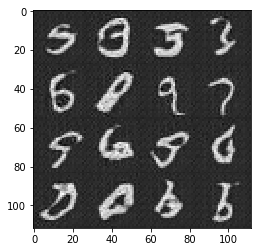

Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 4.8560
Epoch 2/2... Discriminator Loss: 3.6303... Generator Loss: 0.0700
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 5.1863
Epoch 2/2... Discriminator Loss: 0.3097... Generator Loss: 1.7386
Epoch 2/2... Discriminator Loss: 0.1898... Generator Loss: 3.7962
Epoch 2/2... Discriminator Loss: 0.2005... Generator Loss: 2.9588
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.2391... Generator Loss: 2.0428


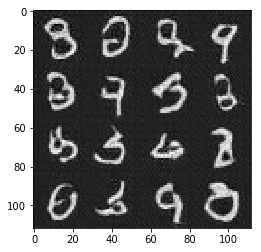

Epoch 2/2... Discriminator Loss: 0.0557... Generator Loss: 4.7626
Epoch 2/2... Discriminator Loss: 2.9307... Generator Loss: 0.2486
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.8563
Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 0.3154... Generator Loss: 1.6028
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 1.4405


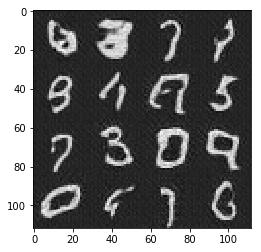

Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 1.6607
Epoch 2/2... Discriminator Loss: 0.5591... Generator Loss: 1.4990
Epoch 2/2... Discriminator Loss: 2.6271... Generator Loss: 0.3380
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.5981
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 2.8029
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 4.9744
Epoch 2/2... Discriminator Loss: 0.2295... Generator Loss: 2.1943
Epoch 2/2... Discriminator Loss: 0.3084... Generator Loss: 1.8406
Epoch 2/2... Discriminator Loss: 0.3226... Generator Loss: 3.0249
Epoch 2/2... Discriminator Loss: 0.1790... Generator Loss: 6.5115


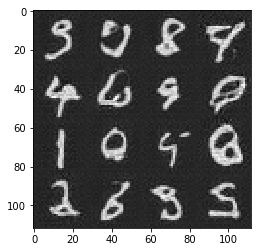

saving generator.ckpt


In [32]:
batch_size = 10
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 2.2322
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 13.5885
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.3375
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 7.5246
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 15.5852
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 4.0344
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 3.1817
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 2.1277


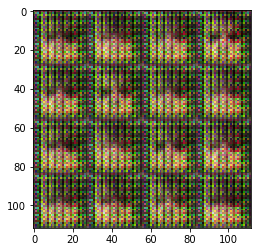

Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 15.8251
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.0999
Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 7.2173
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 5.5569
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 11.5052
Epoch 1/1... Discriminator Loss: 0.0728... Generator Loss: 2.9151
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 7.4024
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 3.6671
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 3.4459
Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 3.0482


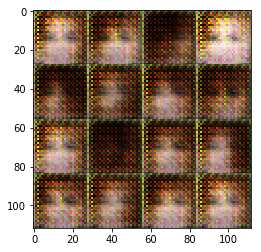

Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 6.8735
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 6.7052
Epoch 1/1... Discriminator Loss: 0.1002... Generator Loss: 4.6520
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 5.9140
Epoch 1/1... Discriminator Loss: 0.2890... Generator Loss: 2.6094
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.0545
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 3.3916
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.3169... Generator Loss: 2.4688
Epoch 1/1... Discriminator Loss: 0.2005... Generator Loss: 4.2067


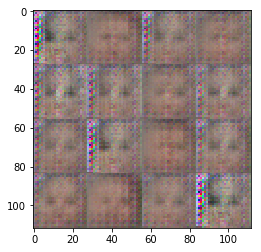

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 7.4014
Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 2.5712
Epoch 1/1... Discriminator Loss: 1.7380... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 7.5915
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 5.1468
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 2.1315
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 1.5806
Epoch 1/1... Discriminator Loss: 0.3075... Generator Loss: 2.2610
Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 5.3902


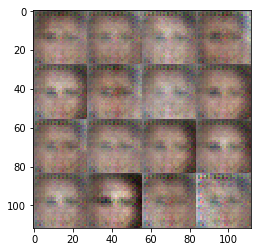

Epoch 1/1... Discriminator Loss: 5.2093... Generator Loss: 3.0482
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 2.0522
Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 2.2414
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 3.0526
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 5.1611
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 7.0839
Epoch 1/1... Discriminator Loss: 0.2632... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 6.4423
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 4.3938
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 6.9953


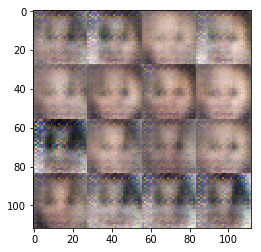

Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.1995
Epoch 1/1... Discriminator Loss: 0.1419... Generator Loss: 2.5355
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.4149
Epoch 1/1... Discriminator Loss: 0.1449... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 5.7592
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 4.5979
Epoch 1/1... Discriminator Loss: 0.2339... Generator Loss: 5.2603
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 10.5351


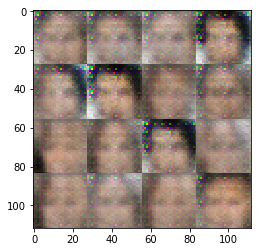

Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 9.7663
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 2.1959... Generator Loss: 0.1735
Epoch 1/1... Discriminator Loss: 0.0624... Generator Loss: 5.4873
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 5.9264
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 5.6892
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 5.4025
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 2.1307
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 6.0870
Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 6.0705


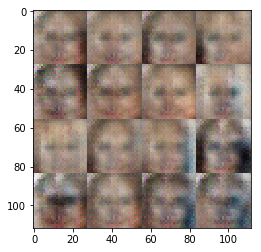

Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 7.5506
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 4.7819
Epoch 1/1... Discriminator Loss: 0.0642... Generator Loss: 3.2683
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 8.8217
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 3.9199
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.4594
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 4.9913
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 6.5025


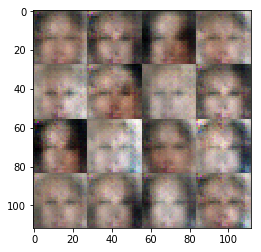

Epoch 1/1... Discriminator Loss: 0.2547... Generator Loss: 6.1560
Epoch 1/1... Discriminator Loss: 0.2545... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 2.5930
Epoch 1/1... Discriminator Loss: 3.3849... Generator Loss: 0.0521
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 3.9894
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.4761
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 1.9115
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 6.9249
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 2.6552
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 2.6487


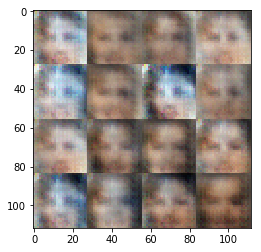

Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 3.1355
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 4.5249
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.5546
Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 5.5049
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 2.7206
Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 6.8046
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 10.4221


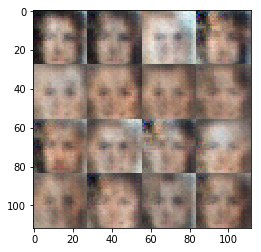

Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 7.3935
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 2.8295
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 6.9746
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 2.1371
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 7.5035
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 1.6936
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 6.6201
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 7.6272
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 8.3405


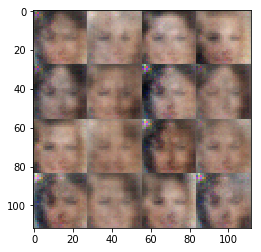

Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 7.3711
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 5.0915
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 3.9806
Epoch 1/1... Discriminator Loss: 2.6392... Generator Loss: 0.1195
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 4.3625
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 3.2555
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 2.9559
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 2.3366
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 5.7519


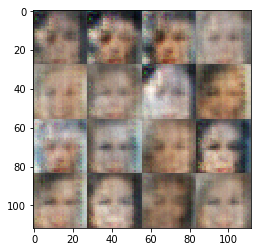

Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 1.8313
Epoch 1/1... Discriminator Loss: 0.0433... Generator Loss: 3.7317
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.7356
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 1.9278
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 5.1128
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 7.9348
Epoch 1/1... Discriminator Loss: 0.1765... Generator Loss: 5.8602
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 3.9689
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 3.9090
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 7.2866


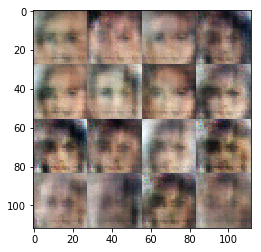

Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 3.8332
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 8.6617
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 2.5277
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 3.9929
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 5.7319
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 9.2271
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 4.9755
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 6.3864
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 2.3678


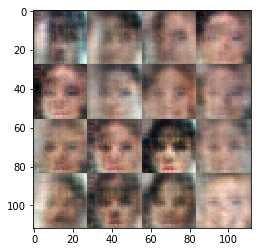

Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 0.2300... Generator Loss: 5.7899
Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 3.2693
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 8.0724
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 7.5441
Epoch 1/1... Discriminator Loss: 2.3180... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 1.8958... Generator Loss: 0.2417
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 4.5300
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 11.4473


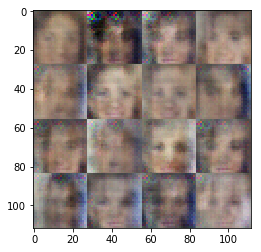

Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 5.2395
Epoch 1/1... Discriminator Loss: 0.2184... Generator Loss: 2.1169
Epoch 1/1... Discriminator Loss: 0.2012... Generator Loss: 8.1989
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 7.6512
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 3.1535
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 4.1394
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 4.7158
Epoch 1/1... Discriminator Loss: 0.2849... Generator Loss: 1.7577
Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 8.7003


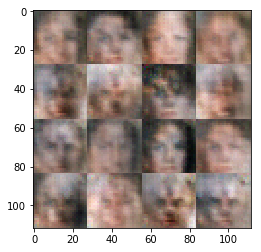

Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 5.2899
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 2.7223
Epoch 1/1... Discriminator Loss: 2.2988... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 2.7141... Generator Loss: 0.1464
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 2.7070
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 6.1131
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.2962
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 2.7352
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 7.1191


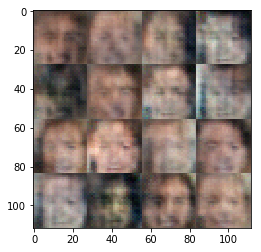

Epoch 1/1... Discriminator Loss: 2.9728... Generator Loss: 0.0843
Epoch 1/1... Discriminator Loss: 0.1751... Generator Loss: 5.3555
Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 6.7279
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 8.4566
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 5.1406
Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 3.2091
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4967


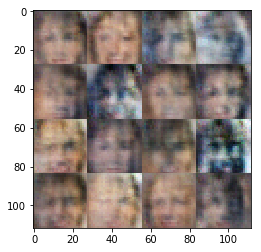

Epoch 1/1... Discriminator Loss: 2.4177... Generator Loss: 4.3439
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 3.7207
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 4.7771
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 6.7193
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 6.7366
Epoch 1/1... Discriminator Loss: 0.1591... Generator Loss: 2.9091
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 3.5997


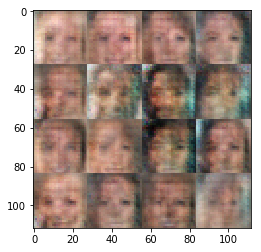

Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 0.0358... Generator Loss: 6.1889
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 4.5654
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.7236
Epoch 1/1... Discriminator Loss: 0.0535... Generator Loss: 6.1807
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 3.4626
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 4.9556
Epoch 1/1... Discriminator Loss: 0.2323... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 5.2265
Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 3.3095


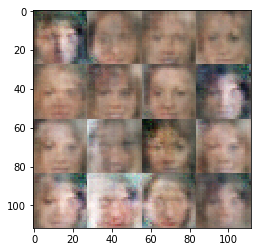

Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 2.3759
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.0972... Generator Loss: 5.4155
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.6095
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 5.2291
Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 3.5985
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 5.8685
Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 1.7981
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 2.5895
Epoch 1/1... Discriminator Loss: 0.2406... Generator Loss: 2.5459


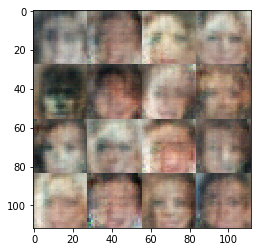

Epoch 1/1... Discriminator Loss: 0.3077... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.0341
Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 8.1965
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.2373
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 6.8661
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 5.6369
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 2.6725
Epoch 1/1... Discriminator Loss: 1.8610... Generator Loss: 0.1904
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 8.9152


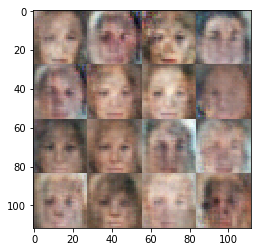

Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 4.2836
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.2422
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 4.0798
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 8.3060
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 6.8732
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 1.8287
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 6.1603
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 1.9029
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.3872


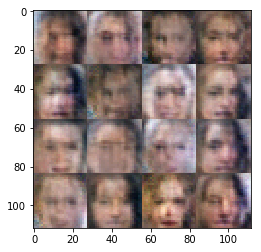

Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 4.7442
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 4.5552
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.2772
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 3.3688
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 5.8498
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 3.7088


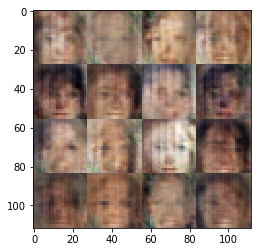

Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 0.1404... Generator Loss: 2.4181
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 2.9803
Epoch 1/1... Discriminator Loss: 3.3766... Generator Loss: 0.0485
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 6.0243
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 2.8400
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 5.1153
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 7.7205


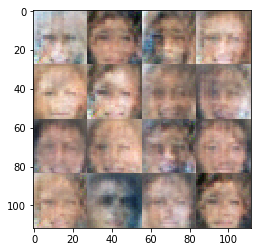

Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 4.3347
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 3.9275
Epoch 1/1... Discriminator Loss: 2.5207... Generator Loss: 0.1550
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 0.2152... Generator Loss: 2.3744
Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 4.3300
Epoch 1/1... Discriminator Loss: 0.0654... Generator Loss: 3.6568
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 4.2569
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 3.8316


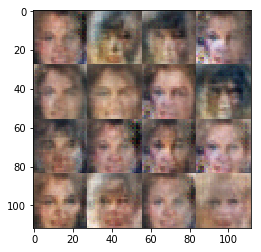

Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 5.9079
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 6.1047
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 5.3827
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 8.4148
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 2.5953... Generator Loss: 0.0854
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 0.0641... Generator Loss: 4.2450
Epoch 1/1... Discriminator Loss: 0.1171... Generator Loss: 3.5810
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.0216


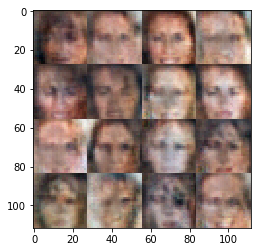

Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 5.1986
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 5.7402
Epoch 1/1... Discriminator Loss: 0.3249... Generator Loss: 8.9102
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 6.3030
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 4.6424
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 7.9992
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.1446... Generator Loss: 2.9717


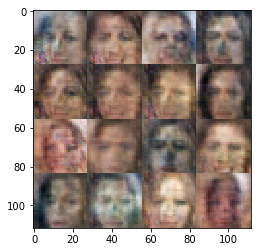

Epoch 1/1... Discriminator Loss: 3.1803... Generator Loss: 0.0672
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.2847
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 9.2455
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 7.9946
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 4.8521
Epoch 1/1... Discriminator Loss: 1.7850... Generator Loss: 0.2303
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 6.7440
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 5.2492
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 4.3957


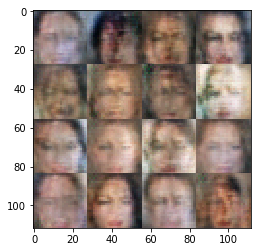

Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 8.1418
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 4.3367
Epoch 1/1... Discriminator Loss: 0.1336... Generator Loss: 3.2005
Epoch 1/1... Discriminator Loss: 0.2616... Generator Loss: 2.5042
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 6.6364
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 1.9842... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 2.2958
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.6430


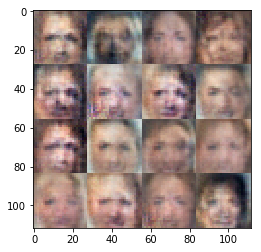

Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 5.2569
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 2.7507
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 3.1736
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 3.6628
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 4.0760
Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 5.0269
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 5.1457
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 4.2673
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 4.8227


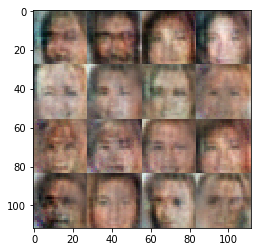

Epoch 1/1... Discriminator Loss: 0.3839... Generator Loss: 6.5590
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 4.2760
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 3.2935
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 5.5839
Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 7.5706
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 6.7630
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.7076
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 2.1301... Generator Loss: 0.1850


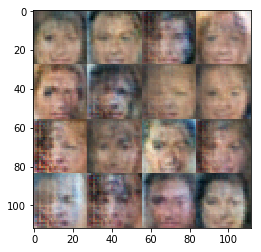

Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 2.4350
Epoch 1/1... Discriminator Loss: 0.1257... Generator Loss: 2.8045
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 2.9425
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 4.3069
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 7.8055
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 2.8981
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 3.0272


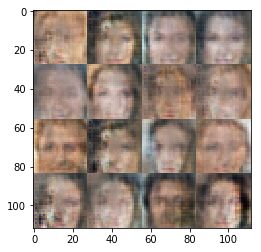

Epoch 1/1... Discriminator Loss: 5.2644... Generator Loss: 6.6307
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 2.4646
Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 5.4698
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 3.7870
Epoch 1/1... Discriminator Loss: 0.2451... Generator Loss: 2.0660
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.2714
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 4.7020


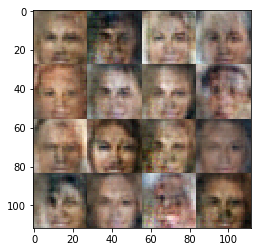

Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 2.2175... Generator Loss: 5.7120
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 1.9102
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 4.5569
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 1.8753... Generator Loss: 0.2105
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.4365


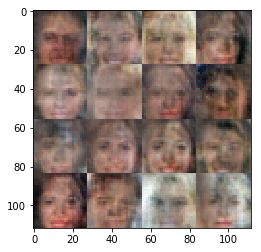

Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 2.7153
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 6.0050
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 0.8914


In [ ]:
batch_size = 10
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.